# Training NN models:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.cluster import MiniBatchKMeans
import joblib
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from DataGenerator import DataGenerator_Sup

Using TensorFlow backend.


Get a list of all files:

In [2]:
Ad_folder = '../Data/audio_ads' # audio files location

pos_files = []
for r,d,f in os.walk(Ad_folder):
    for filename in f:
        if '.mp3' in filename:
            pos_files.append(os.path.join(Ad_folder,filename))

Music_folder = '../Data/Music' # audio files location

neg_files = []
for r,d,f in os.walk(Music_folder):
    for filename in f:
        if '.mp3' or '.au' in filename:
            neg_files.append(os.path.join(r,filename))

How many mp3 files do we have?

In [3]:
n_pos_files = len(pos_files)
n_neg_files = len(neg_files)

print('We have ' + str(n_pos_files) + ' positive examples')
print('We have ' + str(n_neg_files) + ' negative examples')

We have 2303 positive examples
We have 1023 negative examples


### Define utility functions:

In [4]:
def create_model(n_features):
    '''Create a model obejct with an input of length n_features'''
    model = Sequential() # create a model instance

    #add model layers
    model.add(Dense(256, activation = 'relu', input_shape=(n_features,)))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

### Create data generators:

In [5]:
train_size = 0.8 # the fraction of the data used for training 
pos_fraction = 0.5 # the fraction of positives used in training

n_train_pos = int(np.floor(pos_fraction*n_pos_files*train_size))
n_train_neg = int(np.floor(n_neg_files*train_size))
n_test_pos = int(np.floor(pos_fraction*n_pos_files - n_train_pos))
n_test_neg = n_neg_files - n_train_neg
train_files_pos = pos_files[:n_train_pos]
train_files_neg = neg_files[:n_train_neg]
test_files_pos = pos_files[n_train_pos:n_train_pos + n_test_pos]
test_files_neg = neg_files[n_train_neg:n_train_neg + n_test_neg]

train_generator = DataGenerator_Sup(train_files_pos, train_files_neg, dataset='train')
test_generator = DataGenerator_Sup(test_files_pos, test_files_neg, dataset='test')

Check generators:

In [6]:
if 1:
    X, Y = train_generator.__getitem__(0) # get item
    print(X.shape)
    print(Y.shape)
    print('Positive example fraction in batch is ' + str((sum(Y == 1)/Y.shape[0])[0]))

(129, 1690)
(129, 1)
Positive example fraction in batch is 0.6124031007751938


### Train NN model:

Create and compile model:

In [7]:
num_features = 1690
model = create_model(num_features)
filepath = 'models/weights_1690_256_64_1.hdf5'
checkpoint = ModelCheckpoint(filepath)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


Train model:

In [9]:
H = model.fit_generator(generator = train_generator, epochs = 1, callbacks = [checkpoint])

Epoch 1/1
173/173 [==============================] - 2216s 13s/step - loss: 0.3135 - acc: 0.8673


Text(0.5, 0, 'epoch')

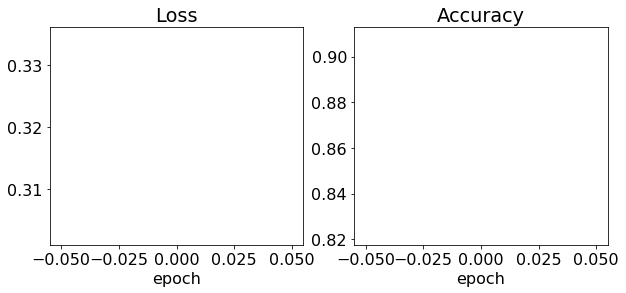

In [10]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize= (10,4))
plt.subplot(1,2,1)
plt.plot(H.history['loss'], linewidth=3, color = 'b')
plt.title('Loss')
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(H.history['acc'], linewidth=3, color = 'g')
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
# Error files:
train_generatorerator.err_files

### Check Accuracy:

In [11]:
# recreate a model for evaluation
num_features = 1690
eval_model = create_model(num_features)
# load weights
eval_model.load_weights('models/weights_1690_256_64_1.hdf5')
# compile
eval_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

What metrics do we use for evaluation?

In [12]:
eval_model.metrics_names

['loss', 'acc']

How does the model perform on the test?

In [ ]:
eval_model.evaluate_generator(generator = test_generator, steps = 1)